<a href="https://colab.research.google.com/github/luiszac/crop-prediction/blob/main/Crop_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Aplicación de técnicas de previsión de series temporales basadas en aprendizaje de máquina para el pronóstico de la producción de principales cultivos de la Región La Libertad##


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

# Import Statsmodels
from statsmodels.tsa.arima.model import ARIMA

In [4]:
# Data loading
data = pd.read_csv('https://raw.githubusercontent.com/luiszac/crop-prediction/main/cultivos.csv')
data.head()
data.describe()

,Esparrago,Maiz amarillo duro,Palta,Uva,Temperatura,Precipitacion,Humedad,IS_esparrago,IS_Maiz amarillo duro,IS_palta,IS_Uva
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.00000,240.000000,240.000000,240.000000
mean,12251.373292,16490.317292,6831.960000,3890.101833,21.238375,2.548667,77.415750,12582.39400,9693.185708,8343.180000,2476.352750
std,3809.370580,13468.194877,11753.871964,868.839557,2.497504,4.805042,2.592122,3312.25885,4230.923079,5790.064751,727.733613
min,5216.000000,1822.800000,240.000000,2740.500000,15.600000,0.000000,69.840000,6714.00000,2903.500000,1680.000000,1697.030000
25%,9232.525000,7274.500000,1168.325000,3390.202500,19.372500,0.072500,75.787500,9024.18000,5776.750000,2348.750000,1947.630000
50%,12068.750000,11764.250000,2522.700000,3666.550000,20.900000,0.600000,77.530000,13694.84000,9655.850000,8570.700000,2088.930000
75%,14058.950000,21942.450000,5869.337500,4142.000000,23.500000,2.425000,79.212500,14892.45000,13133.150000,14704.925000,3180.275000
max,24878.100000,74623.700000,70140.110000,8032.300000,26.800000,42.600000,83.510000,17734.30000,19828.500000,16248.800000,3995.000000


In [ ]:
# Index change according to period date in dataset
data.Periodo=pd.to_datetime(data.Periodo,dayfirst=True)
data.set_index("Periodo",inplace=True)

Total samples: 240
             value
Periodo           
2001-01-01  8674.0
2001-02-01  7448.4
2001-03-01  7564.5
2001-04-01  7023.0
2001-05-01  5683.0


<Axes: xlabel='Periodo'>

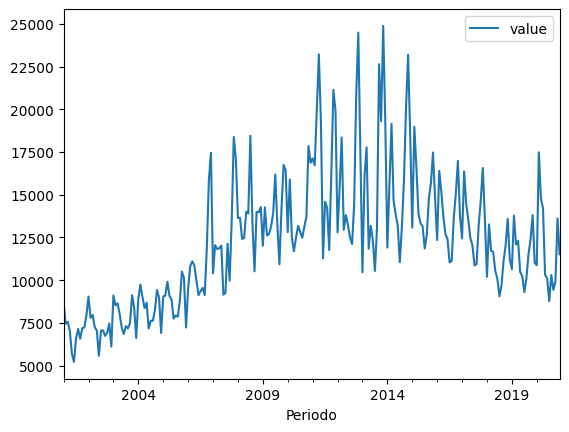

In [ ]:
# We start analyzing the Esparrago variable behavior in the last 2 years
df = data[['Esparrago']].rename(columns={'Esparrago': 'value'})
print(f"Total samples: {len(df)}")
print(df.head())
df.plot()

##Modelo ARIMA##


¿Cómo elegir los parámetros del modelo ARIMA?
Existen múltiples enfoques para establecer los parámetros ARIMA, ya que pueden determinarse observando las propiedades de los datos o empíricamente ajustando el modelo y evaluando el rendimiento. Además, observaremos los gráficos de la función de autocorrelación (ACF) y de la función de autocorrelación parcial (ACF) para identificar la correlación general de los datos. Además, para determinar las propiedades de las series temporales, se puede emplear el cálculo de la media móvil y la desviación típica o pruebas existentes como la prueba Dickey Fuller aumentada o ADF. Examinaremos estas técnicas más adelante. Sin embargo, aún necesitamos saber cómo establecer los tres parámetros fundamentales del modelo ARIMA.


¿Cómo elegir p, d y q para el modelo ARIMA de Python?
El primer paso sería tener en cuenta los supuestos discutidos anteriormente. Para ello, tenemos que determinar el orden de diferenciación "d". Comprobemos primero el gráfico de autocorrelación. El paquete statsmodel puede ayudarnos con esto

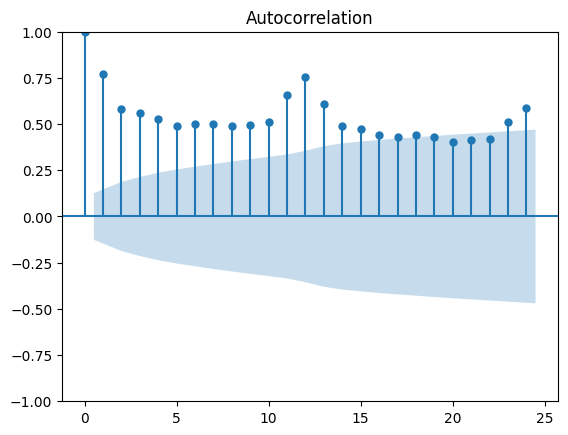

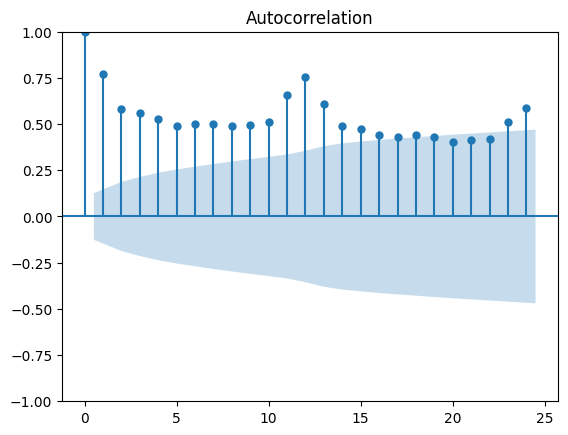

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.value)

Claramente, los datos no son ideales para que el modelo ARIMA de Python inicie directamente el entrenamiento autorregresivo. Así que vamos a ver cómo el segmento de diferenciación del modelo ARIMA Python hace que los datos estacionarios.

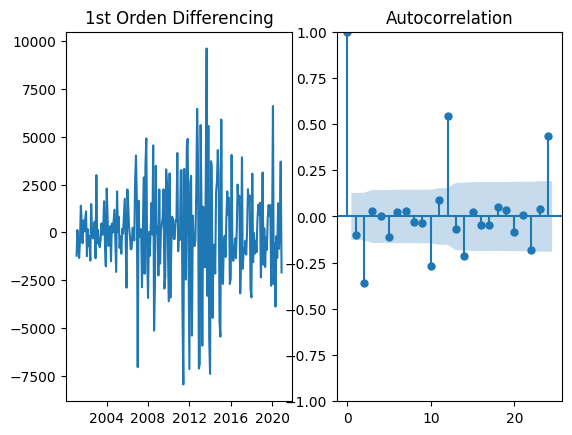

In [ ]:
f = plt.figure()

ax1 = f.add_subplot(121)
ax1.set_title('1st Orden Differencing')
ax1.plot(df.value.diff())

ax2 = f.add_subplot(122)
plot_acf(df.value.diff().dropna(), ax=ax2)
plt.show ()

Como se ha visto anteriormente, la diferenciación de primer orden altera considerablemente la autocorrelación. También podemos probar la diferenciación de segundo orden para reforzar la estacionariedad.



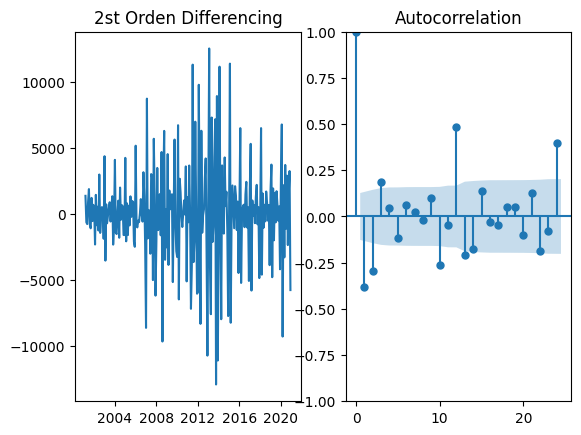

In [ ]:
f = plt.figure()

ax1 = f.add_subplot(121)
ax1.set_title('2st Orden Differencing')
ax1.plot(df.value.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(df.value.diff().diff().dropna(), ax=ax2)
plt.show ()

A partir del gráfico de autocorrelación, podemos decidir si se necesita más diferenciación. Si colectivamente las autocorrelaciones, o el punto de datos de cada retardo (en el eje horizontal), son positivos durante varios retardo consecutivos, podría ser necesario diferenciar más. Por el contrario, si más puntos de datos son negativos, la serie está sobrediferenciada.

Sin embargo, se puede emplear una prueba más matemática para determinar qué orden es el mejor para los datos en cuestión. La prueba Dickey-Fuller aumentada es una de esas medidas que proporciona fácilmente statsmodel. La prueba ADF pretende rechazar la hipótesis nula de que los datos de la serie temporal dada no son estacionarios. Calcula el valor p y lo compara con un valor umbral o nivel de significación de 0,05. Si el valor p es inferior a 0,05, la prueba ADF se realiza de forma automática. Si el valor p es inferior a este nivel, los datos son estacionarios; de lo contrario, el orden de diferenciación se incrementa en uno.

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.value.dropna())
print('p-value: ', result[1])

result = adfuller(df.value.diff().dropna())
print('p-value 1 diff: ', result[1])

result = adfuller(df.value.diff().diff().dropna())
print('p-value 2 diff: ', result[1])

p-value:  0.4138419585444674
p-value 1 diff:  6.212347310893929e-12
p-value 2 diff:  3.84691668095627e-15


Como vemos más arriba, después de la diferenciación de 1º orden, el valor p cae por encima del umbral aceptable. Por lo tanto, podemos considerar que el orden de diferenciación ("d") es 2. Esto se corresponde bien con el gráfico de la línea de autocorrelación visto anteriormente. Sin embargo, el valor p para el 0 orden está mucho más cerca del umbral, por lo que, para ser conservadores, consideraremos "d" como 0 y veremos cómo se comporta el modelo.

El siguiente paso en el modelo ARIMA es calcular "p", o el orden del modelo autorregresivo. Podemos inspeccionar el gráfico de autocorrelación parcial, que mide la correlación entre los datos de la serie temporal y un determinado desfase. En función de la presencia o ausencia de correlación, podemos determinar si el desfase o el orden son necesarios o no.

Matemáticamente en la ecuación siguiente, la autocorrelación parcial de las series y un retardo sería el coeficiente de ese retardo (alfa) -

<img src="https://dezyre.gumlet.io/images/blog/how-to-build-arima-model-in-python/image_36516828181641822385014.jpg?w=1200&dpr=1.0" alt="Descripción de la imagen">

Así, determinamos "p" basándonos en el desfase más significativo del gráfico de autocorrelación parcial. Podemos comprobar el gráfico hasta la diferencia de segundo orden para estar seguros.

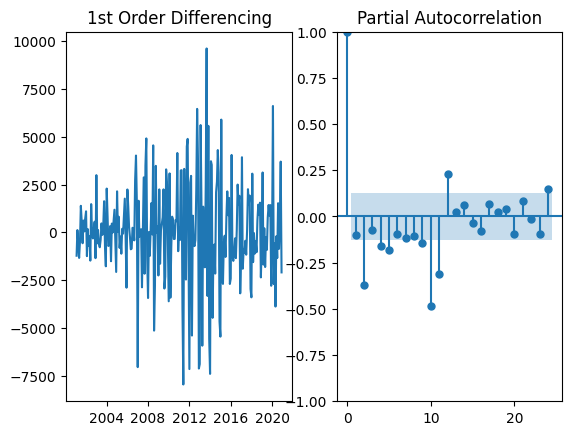

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df.value.diff())

ax2 = f.add_subplot(122)
plot_pacf(df.value.diff().dropna(),ax=ax2)
plt.show()

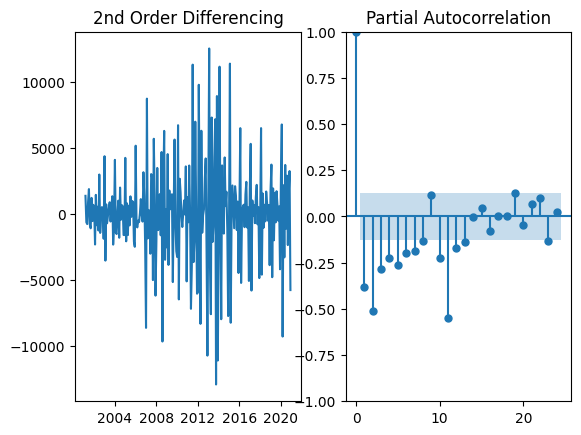

In [ ]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(df.value.diff().diff())

ax2 = f.add_subplot(122)
plot_pacf(df.value.diff().diff().dropna(),ax=ax2)
plt.show()

En ambos gráficos, vemos que el primer retardo es el más significativo. Por lo tanto, consideramos que "p" es 1.

Por último, "q" puede estimarse de forma similar observando el gráfico ACF en lugar del gráfico PACF. Observando el número de rezagos que cruzan el umbral, podemos determinar qué parte del pasado sería lo suficientemente significativa como para tenerla en cuenta para el futuro. Los que tienen una alta correlación contribuyen más y serían suficientes para predecir valores futuros. A partir de los gráficos anteriores, el parámetro de media móvil (MA) se puede establecer en 2.

Así, nuestro modelo Python ARIMA final puede definirse como ARIMA(p=1, d=1, q= 2).

#¿Cómo ajustar ARIMA en Python?
Utilizando la clase ARIMA del módulo statsmodels.tsa.arima_model, podemos introducir los datos y los hiperparámetros p, d y q (en ese orden). Al llamar al método fit() de este módulo se obtiene un modelo entrenado que se utiliza para la evaluación y la inferencia.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df.value, order=(1,1,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  240
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2181.367
Date:                Fri, 22 Sep 2023   AIC                           4370.735
Time:                        19:05:44   BIC                           4384.640
Sample:                    01-01-2001   HQIC                          4376.338
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0612      0.134      0.455      0.649      -0.202       0.325
ma.L1         -0.3797      0.113     -3.351      0.001      -0.602      -0.158
ma.L2         -0.4675      0.075     -6.205      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#¿Cómo interpretar los resultados del ejemplo ARIMA en Python?#
Como se ha visto anteriormente, el resumen del modelo proporciona varias medidas estadísticas para evaluar el rendimiento del modelo ARIMA en Python. Además, también conocemos los valores de los coeficientes para cada uno de los parámetros. Como mantuvimos el valor del parámetro MA o "q" como 2, tenemos dos coeficientes entrenados para MA y uno para AR.

Aparte de eso vemos las puntuaciones como Akaike Information Critera (AIC), Bayesian Information Criterion (BIC), Hannan-Quinn Information Criterion (HQIC), y la desviación estándar de las innovaciones (innovaciones son la diferencia del valor real en el momento t y el valor predicho en ese momento).

#¿Cómo obtener el AIC para el ejemplo ARIMA Forecast Python?#
El Criterio de Información de Akaike o AIC es una buena medida para comprobar la bondad del ajuste matemático del modelo. Las puntuaciones del Criterio de Información miden la cantidad de información perdida al entrenar y generalizar el modelo ARIMA. El AIC debe ser lo más bajo posible. Visualizando el resumen del modelo ARIMA entrenado en Python desde statsmodel, podemos comprobar las puntuaciones AIC y otras medidas estadísticas de rendimiento.

Para reducir el AIC, podemos intentar cambiar los valores de p, q y d o utilizar técnicas de entrenamiento como la validación cruzada k. Por ejemplo, cambiar el valor de "d" a 1 en lugar de 0 reduce el AIC a alrededor de 4370.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df.value, order=(2,1,10))
model = arima_model.fit()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  240
Model:                ARIMA(2, 1, 10)   Log Likelihood               -2166.669
Date:                Fri, 22 Sep 2023   AIC                           4359.338
Time:                        19:07:45   BIC                           4404.532
Sample:                    01-01-2001   HQIC                          4377.550
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4741      0.107     -4.424      0.000      -0.684      -0.264
ar.L2         -0.7897      0.093     -8.524      0.000      -0.971      -0.608
ma.L1          0.1341      0.130      1.030      0.3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Sin embargo, medidas como el AIC, el BIC y el HQIC dependen en gran medida de la probabilidad aprendida de los datos. Al cambiar "d" (entre 0, 1 y 2), cambiamos efectivamente la distribución de los datos y, por tanto, el cálculo de la verosimilitud. No sería un método adecuado para determinar qué valor de "d" deberíamos utilizar. Por lo tanto, los diferentes AIC que obtuvimos cambiando "d" no son directamente comparables. Pero aún así, podemos ver a partir del parámetro mencionado en el método de selección anterior que d=1 sería una mejor elección en general.

Sin embargo, las puntuaciones del Criterio de Información son excelentes para determinar los valores óptimos de "p" y "q". Por ejemplo, cambiar el valor de p y q a 2 redujo el AIC en 11 unidades.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df.value, order=(1,1,1))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -102.288
Date:                Fri, 22 Sep 2023   AIC                            210.577
Time:                        18:32:18   BIC                            211.771
Sample:                    01-01-2020   HQIC                           209.824
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7462      0.300     -2.487      0.013      -1.334      -0.158
ma.L1          0.9943      0.815      1.219      0.223      -0.604       2.592
sigma2      6.772e+06   1.34e-07   5.05e+13      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

#¿Cómo Graficar en Python los Resultados del Pronóstico ARIMA?
Para comprobar lo bien que el modelo entrenado se ajusta a los datos de la serie temporal, podemos utilizar el método plot_predict del modelo entrenado ARIMA forecast python para trazar los valores reales y pronosticados uno encima del otro. Este gráfico de líneas se calcula a partir de los pesos aprendidos y entrenados por el modelo. Comprobemos qué tal funciona la predicción basada en los coeficientes aprendidos

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


240


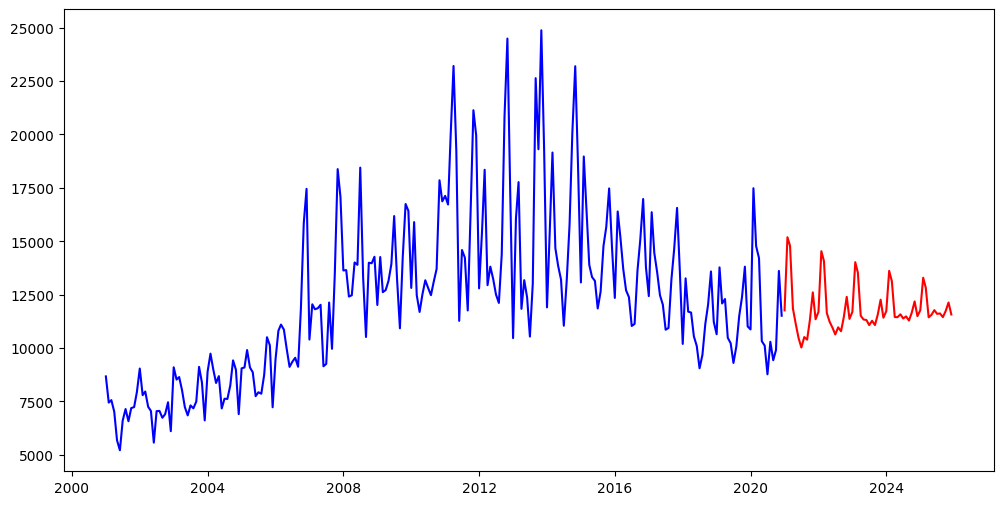

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Ajusta tu modelo ARIMA
arima_model = ARIMA(df['value'], order=(10, 0, 10))
model = arima_model.fit()

# Realiza predicciones
forecast, stderr, conf_int = model.forecast(steps=60),model.forecast(steps=60),model.forecast(steps=60)  # Cambia 10 al número deseado de pasos a predecir
print(len(df))

plt.figure(figsize=(12, 6))
plt.plot(df['value'], label='Datos de entrenamiento', color='blue')
plt.plot( forecast, label='Predicciones', color='red')


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX